#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Scrambled-peptide generator (multiset permutations) with streaming scoring,
progress/ETA, CSV output, and final plots (Top-10 bar chart and scatter of
scrambling metrics).

- Generates UNIQUE permutations for sequences with duplicates (multiset),
  using a counting backtracking generator (no in-memory sets).
- Scores each sequence by three “more-scrambled-is-better” metrics:
    1) Kendall tau inversions (primary)
    2) Hamming distance to the original (secondary)
    3) Spearman footrule distance (tertiary)
- Streams results to CSV in batches; prints periodic progress with ETA.
- Keeps Top-K (by lexicographic order of the 3 metrics) for plotting.
- Keeps a small reservoir sample for a metrics scatter plot to avoid OOM.

NOTE: The full unique-permutation space for the default sequence is large
(29,937,600). Start with MAX_TO_PROCESS to test. Consider running on a
compute node for full enumeration.
"""

In [2]:
import csv
import math
import os
import time
import heapq
from collections import Counter, defaultdict
from typing import Generator, Iterable, List, Optional, Tuple


Configuration

In [3]:
ORIG = "HHGANSLGLVQS"                   # Original peptide (composition preserved)
OUT_CSV = "scrambled_all_stream1.csv"    # Streaming CSV (append mode)

PROGRESS_EVERY = 500                 # Print progress every N sequences
SAVE_EVERY = 1000                    # Flush/write CSV every N sequences
MAX_TO_PROCESS: Optional[int] = None    # None = full; else stop early (e.g., 500_000)

Resume: if set to a known sequence already emitted, resume AFTER that sequence

In [4]:
RESUME_AFTER: Optional[str] = None

Plots & summaries

In [5]:
TOP_K = 10                              # Keep top-K sequences for the bar chart
SAMPLE_POINTS = 5000                    # Reservoir size for scatter plot sampling
TOP10_BARS_PNG = "top10_bars.png"
SCATTER_PNG = "metrics_scatter.png"

Utilities: occurrence indexing for duplicates

In [6]:
def indexed_positions(seq: str):
    """
    Tag each residue with its occurrence index, e.g., H#0, H#1, ...
    This creates a 1-1 mapping even when residues repeat.
    """
    counts = defaultdict(int)
    out = []
    for ch in seq:
        out.append((ch, counts[ch]))
        counts[ch] += 1
    return out


ORIG_INDEXED = indexed_positions(ORIG)
ORIG_POS_MAP = {key: i for i, key in enumerate(ORIG_INDEXED)}
N = len(ORIG)


def make_indexed(seq: str):
    counts = defaultdict(int)
    out = []
    for ch in seq:
        out.append((ch, counts[ch]))
        counts[ch] += 1
    return out

Three scrambling metrics

In [7]:
def hamming(a: str, b: str) -> int:
    """Hamming distance: number of positions where a and b differ."""
    return sum(1 for x, y in zip(a, b) if x != y)


def footrule(new_seq: str) -> int:
    """Spearman footrule distance: sum of absolute rank shifts (with occurrence tags)."""
    new_indexed = make_indexed(new_seq)
    s = 0
    for new_pos, key in enumerate(new_indexed):
        s += abs(new_pos - ORIG_POS_MAP[key])
    return int(s)


def kendall_tau_inversions(new_seq: str) -> int:
    """Kendall tau inversion count: inversions of the original-position permutation."""
    new_indexed = make_indexed(new_seq)
    perm = [ORIG_POS_MAP[key] for key in new_indexed]  # permutation of 0..N-1

    def merge_count(arr: List[int]) -> Tuple[List[int], int]:
        if len(arr) <= 1:
            return arr, 0
        mid = len(arr) // 2
        left, inv_left = merge_count(arr[:mid])
        right, inv_right = merge_count(arr[mid:])
        i = j = 0
        inv = inv_left + inv_right
        merged: List[int] = []
        while i < len(left) and j < len(right):
            if left[i] <= right[j]:
                merged.append(left[i]); i += 1
            else:
                merged.append(right[j]); j += 1
                inv += len(left) - i
        merged.extend(left[i:])
        merged.extend(right[j:])
        return merged, inv

    return merge_count(perm)[1]


def score_triple(seq: str) -> Tuple[int, int, int]:
    """
    Lexicographic scoring tuple:
        (Kendall inversions, Hamming distance, Footrule distance)
    Higher is better for all three.
    """
    return (
        kendall_tau_inversions(seq),
        hamming(seq, ORIG),
        footrule(seq),
    )


Counting unique permutations (multiset)

In [8]:
def total_unique_perms(seq: str) -> int:
    cnt = Counter(seq)
    num = math.factorial(len(seq))
    for c in cnt.values():
        num //= math.factorial(c)
    return num


TOTAL = total_unique_perms(ORIG)

Unique multiset permutations (lexicographic, memory-light)

In [9]:
def distinct_permutations(seq: str) -> Generator[str, None, None]:
    """
    Backtracking with counts. Produces each unique permutation exactly once,
    in lexicographic order given sorted unique characters.
    """
    counter = Counter(seq)
    chars = sorted(counter.keys())
    path: List[str] = []

    def backtrack(depth: int):
        if depth == N:
            yield "".join(path)
            return
        for ch in chars:
            if counter[ch] == 0:
                continue
            counter[ch] -= 1
            path.append(ch)
            yield from backtrack(depth + 1)
            path.pop()
            counter[ch] += 1

    yield from backtrack(0)


Resume helper

In [10]:
def skip_until(gen: Iterable[str], resume_after: Optional[str]) -> Iterable[str]:
    """
    If resume_after is provided, consume the generator until that sequence
    is encountered, then yield subsequent sequences. Otherwise pass-through.
    """
    if not resume_after:
        for x in gen:
            yield x
        return

    passed = False
    for x in gen:
        if not passed:
            if x == resume_after:
                passed = True
            continue
        yield x

Pretty seconds

In [11]:
def fmt_secs(s: float) -> str:
    if s is None or math.isinf(s):
        return "inf"
    m, s = divmod(int(s), 60)
    h, m = divmod(m, 60)
    if h > 0:
        return f"{h}h{m}m{s}s"
    if m > 0:
        return f"{m}m{s}s"
    return f"{s}s"

Reservoir sampling for scatter

In [12]:
def reservoir_sample_update(sample: List[Tuple[int, int, int]], cap: int, item: Tuple[int, int, int], seen: int):
    """
    Classic reservoir sampling: keep a uniform sample of fixed size 'cap'
    from a stream of length 'seen'.
    """
    if len(sample) < cap:
        sample.append(item)
    else:
        # Replace with probability cap/seen
        # Use a simple LCG-based hash for deterministic choice without importing random
        # (or import random and use random.randrange; both fine)
        import random
        if random.randrange(seen) < cap:
            idx = random.randrange(cap)
            sample[idx] = item


Main streaming loop

In [13]:
def stream_and_score_all():
    import pandas as pd
    import matplotlib.pyplot as plt

    t0 = time.time()
    processed = 0
    batch: List[Tuple[int, str, int, int, int]] = []

    # Top-K (max-heap via nlargest over a min-heap trick)
    # We keep a min-heap of size TOP_K using negated score to emulate lexicographic max.
    # But Python's heapq is a min-heap; we'll store (+) and pop the smallest when exceeding K,
    # comparing naturally since tuples lexicographically compare left-to-right.
    top_heap: List[Tuple[int, int, int, str]] = []  # (inv, ham, fr, seq)

    # Reservoir sample for scatter
    scatter_sample: List[Tuple[int, int, int]] = []  # (inv, ham, fr)

    # Prepare CSV writer (append)
    new_file = not os.path.exists(OUT_CSV)
    f = open(OUT_CSV, "a", newline="", encoding="utf-8")
    writer = csv.writer(f)
    if new_file:
        writer.writerow(["idx", "sequence", "kendall_inversions", "hamming", "footrule"])

    try:
        gen = distinct_permutations(ORIG)
        gen = skip_until(gen, RESUME_AFTER)

        for seq in gen:
            inv, ham, fr = score_triple(seq)
            processed += 1

            # Stream to batch
            batch.append((processed, seq, inv, ham, fr))

            # Maintain Top-K (lexicographic by (inv, ham, fr))
            entry = (inv, ham, fr, seq)
            if len(top_heap) < TOP_K:
                heapq.heappush(top_heap, entry)
            else:
                if entry > top_heap[0]:
                    heapq.heapreplace(top_heap, entry)

            # Update scatter reservoir
            reservoir_sample_update(scatter_sample, SAMPLE_POINTS, (inv, ham, fr), processed)

            # Periodic flush
            if processed % SAVE_EVERY == 0:
                writer.writerows(batch)
                f.flush()
                batch.clear()

            # Progress
            if processed % PROGRESS_EVERY == 0:
                elapsed = time.time() - t0
                rate = processed / elapsed if elapsed > 0 else float("inf")
                remain = (TOTAL - processed) / rate if rate and not math.isinf(rate) else float("inf")
                pct = processed / TOTAL * 100
                print(
                    f"[{processed:,}/{TOTAL:,}] {pct:6.2f}% | "
                    f"elapsed {fmt_secs(elapsed)} | rate {rate:,.1f} seq/s | ETA {fmt_secs(remain)}"
                )

            # Early stop (test mode)
            if MAX_TO_PROCESS is not None and processed >= MAX_TO_PROCESS:
                break

        # Final flush
        if batch:
            writer.writerows(batch)
            f.flush()
            batch.clear()

    finally:
        f.close()

    elapsed = time.time() - t0
    print(f"Done: processed {processed:,} sequences; wrote CSV -> {OUT_CSV}; time {fmt_secs(elapsed)}.")
        # ---------- Prepare summaries & plots ----------
    # Top-K (convert heap to sorted list descending)
    top_list = sorted(top_heap, reverse=True)  # (inv, ham, fr, seq)
    if not top_list:
        print("No data collected for Top-K. Skipping plots.")
        return

    # Build DataFrame for top-K
    top_records = []
    for rank, (inv, ham, fr, seq) in enumerate(top_list, start=1):
        top_records.append(
            {"rank": rank, "sequence": seq, "inversions": inv, "hamming": ham, "footrule": fr}
        )
    df_top = pd.DataFrame(top_records, columns=["rank", "sequence", "inversions", "hamming", "footrule"])
    print("\nTop-K by (inversions, hamming, footrule):")
    print(df_top.to_string(index=False))

    # Plot 1: Top-10 bar chart (Kendall inversions)
    plt.figure(figsize=(10, 4))
    labels = [r["sequence"] for r in top_records]
    inv_vals = [r["inversions"] for r in top_records]
    import numpy as np
    x = np.arange(len(labels))
    plt.bar(x, inv_vals)  # no explicit colors per guidelines
    plt.xticks(x, labels, rotation=45, ha="right")
    plt.ylabel("Kendall tau inversions")
    plt.title("Top-10 scrambled sequences by lexicographic score")
    plt.tight_layout()
    plt.savefig(TOP10_BARS_PNG, dpi=150)
    plt.show()

    print(f"\nSaved figures:\n - {TOP10_BARS_PNG}")

Entry point

Original peptide: HHGANSLGLVQS
Unique permutations (accounting for duplicates): 29,937,600
Output CSV: scrambled_all_stream1.csv
[500/29,937,600]   0.00% | elapsed 0s | rate 34,464.3 seq/s | ETA 14m28s
[1,000/29,937,600]   0.00% | elapsed 0s | rate 30,770.6 seq/s | ETA 16m12s
[1,500/29,937,600]   0.01% | elapsed 0s | rate 35,898.3 seq/s | ETA 13m53s
[2,000/29,937,600]   0.01% | elapsed 0s | rate 39,089.9 seq/s | ETA 12m45s
[2,500/29,937,600]   0.01% | elapsed 0s | rate 41,381.6 seq/s | ETA 12m3s
[3,000/29,937,600]   0.01% | elapsed 0s | rate 41,713.9 seq/s | ETA 11m57s
[3,500/29,937,600]   0.01% | elapsed 0s | rate 43,508.3 seq/s | ETA 11m28s
[4,000/29,937,600]   0.01% | elapsed 0s | rate 42,220.1 seq/s | ETA 11m48s
[4,500/29,937,600]   0.02% | elapsed 0s | rate 42,738.0 seq/s | ETA 11m40s
[5,000/29,937,600]   0.02% | elapsed 0s | rate 42,312.3 seq/s | ETA 11m47s
[5,500/29,937,600]   0.02% | elapsed 0s | rate 42,982.0 seq/s | ETA 11m36s
[6,000/29,937,600]   0.02% | elapsed 0s | rate 43

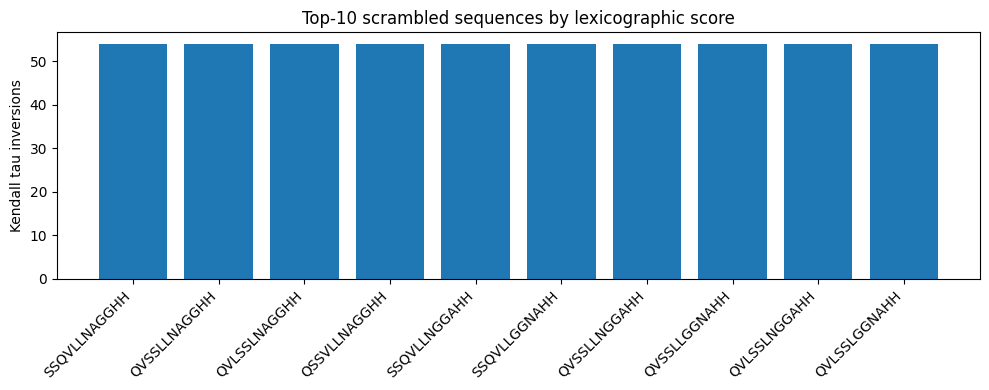


Saved figures:
 - top10_bars.png


In [14]:
if __name__ == "__main__":
    print(f"Original peptide: {ORIG}")
    print(f"Unique permutations (accounting for duplicates): {TOTAL:,}")
    print(f"Output CSV: {OUT_CSV}")
    if RESUME_AFTER:
        print(f"Resuming AFTER sequence: {RESUME_AFTER}")
    if MAX_TO_PROCESS:
        print(f"Dry-run limit: {MAX_TO_PROCESS:,} sequences")
    stream_and_score_all()



# Scrambled-peptide control: convergence analysis & normalized metrics

**This appendix was added without changing the original logic.**  
It provides: (i) length-normalized distances \(\hat K, \hat H, \hat F\),  
(ii) a composite score \(\mathcal{J}\), (iii) convergence plots for
*global restarts + adjacent-swap hill-climbing*, and (iv) a CSV export for SI.

**Reproducibility notes.**
- Random seed is set in the wrapper; change it if needed.
- Plots use matplotlib only; one figure per plot (no subplots).
- Long runs: increase `NUM_RESTARTS` and `LOCAL_STEPS` below.


In [15]:

# === Normalized distances and composite score (drop-in) ===
# Requires that the original notebook defined:
#   ORIG (str), N (int), ORIG_POS_MAP (dict), and the functions:
#   kendall_tau_inversions(seq), hamming(a,b), footrule(seq)

from typing import Tuple

def normalized_distances(seq: str, orig: str = None, n: int = None) -> Tuple[float, float, float]:
    """
    Return length-normalized distances in [0,1]:
      K_hat: 2K / (n*(n-1))      (Kendall tau inversions)
      H_hat: H / n               (Hamming)
      F_hat: F / floor(n^2 / 2)  (Spearman footrule)
    """
    if orig is None:
        orig = ORIG  # provided by the original notebook
    if n is None:
        n = N        # provided by the original notebook
    K = kendall_tau_inversions(seq)
    H = hamming(seq, orig)
    F = footrule(seq)
    K_hat = (2 * K) / (n * (n - 1)) if n > 1 else 0.0
    H_hat = H / n if n > 0 else 0.0
    F_hat = F / (n * n // 2) if n > 1 else 0.0
    return float(K_hat), float(H_hat), float(F_hat)

def composite_J(seq: str, wK: float = 1/3, wH: float = 1/3, wF: float = 1/3) -> float:
    """Composite scrambling score J = wK*K_hat + wH*H_hat + wF*F_hat."""
    K_hat, H_hat, F_hat = normalized_distances(seq)
    return wK * K_hat + wH * H_hat + wF * F_hat


In [16]:

# === Heuristic search with convergence traces (global restarts + adjacent swaps) ===
import random

def hill_climb_adjacent_traced(start_seq: str, steps: int = 1000,
                               w=(1/3,1/3,1/3),
                               rng: random.Random = None):
    """
    Adjacent-swap hill-climbing with a best-so-far trace of J at each step.
    Returns: best_seq, best_J, trace (list[float] length steps+1, including step 0)
    """
    if rng is None:
        rng = random.Random()
    s = start_seq
    best = s
    bestJ = composite_J(s, *w)
    trace = [bestJ]
    for _ in range(steps):
        i = rng.randrange(N-1)  # N should exist in the original notebook
        t = list(s)
        t[i], t[i+1] = t[i+1], t[i]
        t = "".join(t)
        Jt = composite_J(t, *w)
        if Jt > bestJ:          # greedy ascent
            s = t
            best = t
            bestJ = Jt
        trace.append(bestJ)
    return best, bestJ, trace

def scramble_search_with_traces(num_restarts: int = 500, steps: int = 1000,
                                w=(1/3,1/3,1/3),
                                seed: int = 42):
    """
    Global-restart + local hill-climb search that records:
      - per-restart anytime convergence trace (best-so-far J vs step)
      - best-over-restarts progression (saturation curve)
    Returns:
      best_seq, bestJ, traces (list of traces), best_over_restarts (list of floats)
    """
    rng = random.Random(seed)
    base = list(ORIG)     # ORIG provided earlier in the notebook
    best_global = ORIG
    bestJ_global = -1.0
    traces = []
    best_over = []

    for r in range(num_restarts):
        rng.shuffle(base)            # composition-preserving random start
        start = "".join(base)
        cand, Jc, trace = hill_climb_adjacent_traced(start, steps, w, rng)
        traces.append(trace)
        if Jc > bestJ_global:
            best_global, bestJ_global = cand, Jc
        best_over.append(bestJ_global)
    return best_global, bestJ_global, traces, best_over


In [17]:

# === Plotting: anytime convergence (median ± IQR) and saturation over restarts ===
import numpy as np
import matplotlib.pyplot as plt

def plot_anytime_convergence(traces, title="Anytime convergence (median ± IQR)"):
    """traces: list of traces; each an array/list of length steps+1."""
    if not traces:
        print("No traces to plot.")
        return
    T = min(len(t) for t in traces)
    A = np.array([np.array(t[:T], dtype=float) for t in traces])
    med = np.median(A, axis=0)
    q25 = np.percentile(A, 25, axis=0)
    q75 = np.percentile(A, 75, axis=0)

    plt.figure(figsize=(8,4))
    x = np.arange(T)
    plt.plot(x, med, label="median")
    plt.fill_between(x, q25, q75, alpha=0.25, label="IQR")
    plt.xlabel("Local steps")
    plt.ylabel("Best-so-far J")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_restart_saturation(best_over, title="Best-over-restarts (saturation)"):
    if not best_over:
        print("No restart data to plot.")
        return
    plt.figure(figsize=(8,4))
    x = np.arange(1, len(best_over)+1)
    y = np.maximum.accumulate(np.array(best_over, dtype=float))
    plt.plot(x, y)
    plt.xlabel("Restart index")
    plt.ylabel("Best J up to restart")
    plt.title(title)
    plt.tight_layout()
    plt.show()


Best scrambled sequence (by J): QVLLGGSSNAHH
Best composite J: 0.9015151515151514


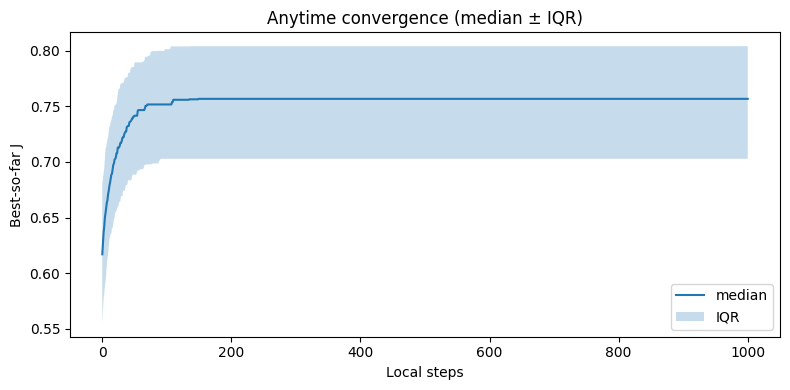

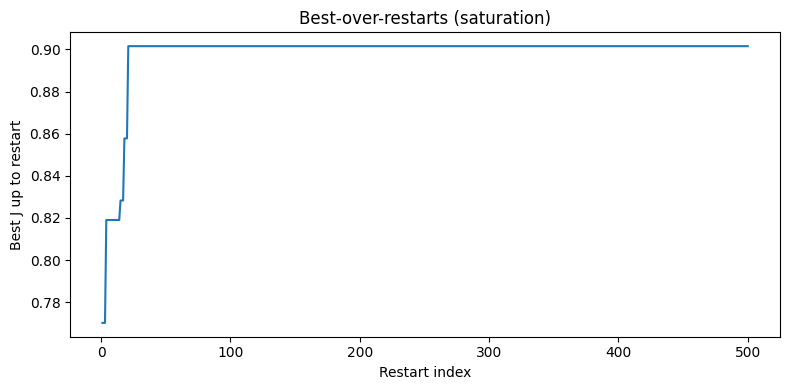

label      sequence   K   H   F     K_hat     H_hat     F_hat  \
0            ORIG  HHGANSLGLVQS   0   0   0  0.000000  0.000000  0.000000   
1  BEST_SCRAMBLED  QVLLGGSSNAHH  52  12  66  0.787879  1.000000  0.916667   
2        RANDOM_1  LSVQNASHGGHL  39  11  58  0.590909  0.916667  0.805556   
3        RANDOM_2  GNVALGHQHLSS  24  10  38  0.363636  0.833333  0.527778   
4        RANDOM_3  HVLQLGGSANSH  37  11  50  0.560606  0.916667  0.694444   
5        RANDOM_4  LLSGGSHQVNHA  39  11  58  0.590909  0.916667  0.805556   
6        RANDOM_5  LHHSNAGGQLSV  15   9  22  0.227273  0.750000  0.305556   

          J  
0  0.000000  
1  0.901515  
2  0.771044  
3  0.574916  
4  0.723906  
5  0.771044  
6  0.427609

In [18]:

# === Run the traced search, make plots, and build/export a metrics table ===
import pandas as pd
from pathlib import Path

# Parameters for quick runs (adjust upward for the final SI figure)
NUM_RESTARTS = 500     # e.g., 500 for paper-quality
LOCAL_STEPS  = 1000     # e.g., 1000 for paper-quality
WEIGHTS = (1/3, 1/3, 1/3)
SEED = 123

best_seq, bestJ, traces, best_over = scramble_search_with_traces(
    num_restarts=NUM_RESTARTS, steps=LOCAL_STEPS, w=WEIGHTS, seed=SEED
)
print("Best scrambled sequence (by J):", best_seq)
print("Best composite J:", bestJ)

# Plots
plot_anytime_convergence(traces, title="Anytime convergence (median ± IQR)")
plot_restart_saturation(best_over, title="Best-over-restarts (saturation)")

# Build a metrics table for ORIG, best_seq, and 5 random shuffles (context)
def raw_and_normalized(seq: str):
    K = kendall_tau_inversions(seq)
    H = hamming(seq, ORIG)
    F = footrule(seq)
    K_hat, H_hat, F_hat = normalized_distances(seq)
    J = composite_J(seq)
    return K, H, F, K_hat, H_hat, F_hat, J

records = []
records.append({
    "label":"ORIG", "sequence": ORIG,
    "K": kendall_tau_inversions(ORIG),
    "H": hamming(ORIG, ORIG),
    "F": footrule(ORIG),
    "K_hat": normalized_distances(ORIG)[0],
    "H_hat": normalized_distances(ORIG)[1],
    "F_hat": normalized_distances(ORIG)[2],
    "J": composite_J(ORIG)
})
records.append({
    "label":"BEST_SCRAMBLED", "sequence": best_seq,
    "K": kendall_tau_inversions(best_seq),
    "H": hamming(best_seq, ORIG),
    "F": footrule(best_seq),
    "K_hat": normalized_distances(best_seq)[0],
    "H_hat": normalized_distances(best_seq)[1],
    "F_hat": normalized_distances(best_seq)[2],
    "J": composite_J(best_seq)
})

import random
rng = random.Random(2025)
base = list(ORIG)
for i in range(5):
    rng.shuffle(base)
    s = "".join(base)
    K,H,F,K_hat,H_hat,F_hat,J = raw_and_normalized(s)
    records.append({"label":f"RANDOM_{i+1}", "sequence": s,
                    "K":K,"H":H,"F":F,"K_hat":K_hat,"H_hat":H_hat,"F_hat":F_hat,"J":J})

df = pd.DataFrame(records, columns=["label","sequence","K","H","F","K_hat","H_hat","F_hat","J"])

# Display dataframe within the notebook when run interactively.
try:
    from caas_jupyter_tools import display_dataframe_to_user
    display_dataframe_to_user("Scrambled metrics table (normalized + raw)", df)
except Exception:
    display(df)


In [21]:
# Config
from pathlib import Path

INPUT_PATH  = Path("scrambled_all_stream1.csv")    # 改成你的路径
OUTPUT_PATH = Path("scrambled_all_stream1_with_norm_sorted.csv")
TMP_DIR     = Path("./_tmp_chunks")                # 临时分块目录（会自动创建/清理）
CHUNK_SIZE  = 200_000                              # 分块大小（行）
WEIGHTS     = (1/3, 1/3, 1/3)                      # (wK, wH, wF)
N_OVERRIDE  = None                                  # 如需手动指定序列长度，填整数；否则自动推断


In [22]:
import pandas as pd
import math

def infer_n_from_file(path: Path, sample_rows: int = 1000) -> int:
    df = pd.read_csv(path, nrows=sample_rows)
    if "sequence" not in df.columns:
        raise ValueError("CSV must contain a 'sequence' column.")
    return int(df["sequence"].astype(str).str.len().mode().iat[0])

def add_normalized_and_J(df: pd.DataFrame, n: int, w=(1/3,1/3,1/3)) -> pd.DataFrame:
    # Expect raw columns: kendall_inversions, hamming, footrule, sequence
    need = {"sequence","kendall_inversions","hamming","footrule"}
    miss = need - set(df.columns)
    if miss:
        raise ValueError(f"Missing columns: {sorted(miss)}")
    denomK = n*(n-1)
    denomF = (n*n)//2
    df = df.copy()
    df["K"] = df["kendall_inversions"].astype(float)
    df["H"] = df["hamming"].astype(float)
    df["F"] = df["footrule"].astype(float)
    df["K_hat"] = (2.0*df["K"])/denomK if denomK>0 else 0.0
    df["H_hat"] = df["H"]/n if n>0 else 0.0
    df["F_hat"] = df["F"]/denomF if denomF>0 else 0.0
    df["J"] = w[0]*df["K_hat"] + w[1]*df["H_hat"] + w[2]*df["F_hat"]
    # Keep only requested columns and sort order later
    cols = ["sequence","K","H","F","K_hat","H_hat","F_hat","J"]
    return df[cols]


In [23]:
import shutil

# Prepare
if TMP_DIR.exists():
    shutil.rmtree(TMP_DIR)
TMP_DIR.mkdir(parents=True, exist_ok=True)

n = N_OVERRIDE if N_OVERRIDE is not None else infer_n_from_file(INPUT_PATH)
print("Sequence length n =", n)

chunk_files = []
reader = pd.read_csv(INPUT_PATH, chunksize=CHUNK_SIZE)
for ci, chunk in enumerate(reader, start=1):
    df = add_normalized_and_J(chunk, n, WEIGHTS)
    df = df.sort_values("J", ascending=False)
    out_chunk = TMP_DIR / f"chunk_{ci:04d}.csv"
    df.to_csv(out_chunk, index=False)
    chunk_files.append(out_chunk)
    print(f"processed chunk {ci} -> {out_chunk.name} ({len(df)} rows)")

print("Total chunks:", len(chunk_files))


Sequence length n = 12
processed chunk 1 -> chunk_0001.csv (200000 rows)
processed chunk 2 -> chunk_0002.csv (200000 rows)
processed chunk 3 -> chunk_0003.csv (200000 rows)
processed chunk 4 -> chunk_0004.csv (200000 rows)
processed chunk 5 -> chunk_0005.csv (200000 rows)
processed chunk 6 -> chunk_0006.csv (200000 rows)
processed chunk 7 -> chunk_0007.csv (200000 rows)
processed chunk 8 -> chunk_0008.csv (200000 rows)
processed chunk 9 -> chunk_0009.csv (200000 rows)
processed chunk 10 -> chunk_0010.csv (200000 rows)
processed chunk 11 -> chunk_0011.csv (200000 rows)
processed chunk 12 -> chunk_0012.csv (200000 rows)
processed chunk 13 -> chunk_0013.csv (200000 rows)
processed chunk 14 -> chunk_0014.csv (200000 rows)
processed chunk 15 -> chunk_0015.csv (200000 rows)
processed chunk 16 -> chunk_0016.csv (200000 rows)
processed chunk 17 -> chunk_0017.csv (200000 rows)
processed chunk 18 -> chunk_0018.csv (200000 rows)
processed chunk 19 -> chunk_0019.csv (200000 rows)
processed chunk 2

In [24]:
import csv
import heapq

def merge_sorted_chunks_by_J_desc(files, out_path: Path):
    # Open readers
    readers = []
    for p in files:
        f = open(p, "r", newline="", encoding="utf-8")
        r = csv.DictReader(f)
        readers.append((f, r))

    # Prepare heap: use negative J for max-heap behavior with Python's min-heap
    heap = []
    for idx, (f, r) in enumerate(readers):
        try:
            row = next(r)
        except StopIteration:
            continue
        # Ensure float
        j = float(row["J"])
        heapq.heappush(heap, (-j, idx, row))

    # Write header
    cols = ["sequence","K","H","F","K_hat","H_hat","F_hat","J"]
    with open(out_path, "w", newline="", encoding="utf-8") as wf:
        w = csv.DictWriter(wf, fieldnames=cols)
        w.writeheader()
        # Pop best and push next from the same file
        while heap:
            negj, idx, row = heapq.heappop(heap)
            # write the row
            w.writerow({c: row[c] for c in cols})
            # advance that reader
            f, r = readers[idx]
            try:
                nxt = next(r)
                heapq.heappush(heap, (-float(nxt["J"]), idx, nxt))
            except StopIteration:
                pass

    # Close readers
    for f, _ in readers:
        f.close()

merge_sorted_chunks_by_J_desc(chunk_files, OUTPUT_PATH)
print("Merged ->", OUTPUT_PATH)


Merged -> scrambled_all_stream1_with_norm_sorted.csv


Saved Top-20 table -> top20_by_J.csv


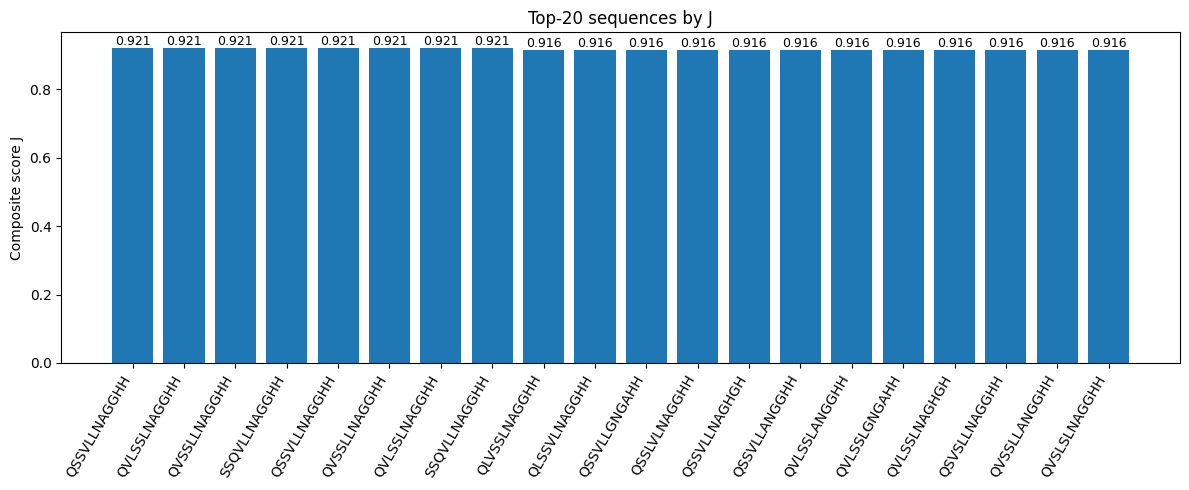

Saved figure -> top20_by_J.png


In [25]:
# Top-20 sequences by J: export figure (+ optional CSV)
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

INPUT_PATH = Path("scrambled_all_stream1_with_norm_sorted.csv")  # 已按J降序排序的CSV
TOPK = 20
OUT_PNG = Path("top20_by_J.png")
OUT_CSV = Path("top20_by_J.csv")

# 读取并取前20
df = pd.read_csv(INPUT_PATH)
top = df.nlargest(TOPK, "J")[["sequence", "J"]].copy()

# 导出前20表格（可选，但通常有用）
top.to_csv(OUT_CSV, index=False)
print(f"Saved Top-20 table -> {OUT_CSV}")

# 画图（matplotlib；单图；不设颜色）
plt.figure(figsize=(12, 5))
x = range(len(top))
bars = plt.bar(x, top["J"].values)
plt.xticks(ticks=x, labels=top["sequence"].astype(str).tolist(), rotation=60, ha="right")
plt.ylabel("Composite score J")
plt.title("Top-20 sequences by J")

# 在柱子上标 J 数值（保留三位小数）
for rect, val in zip(bars, top["J"].values):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, f"{val:.3f}",
             ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.savefig(OUT_PNG, dpi=200)
plt.show()
print(f"Saved figure -> {OUT_PNG}")


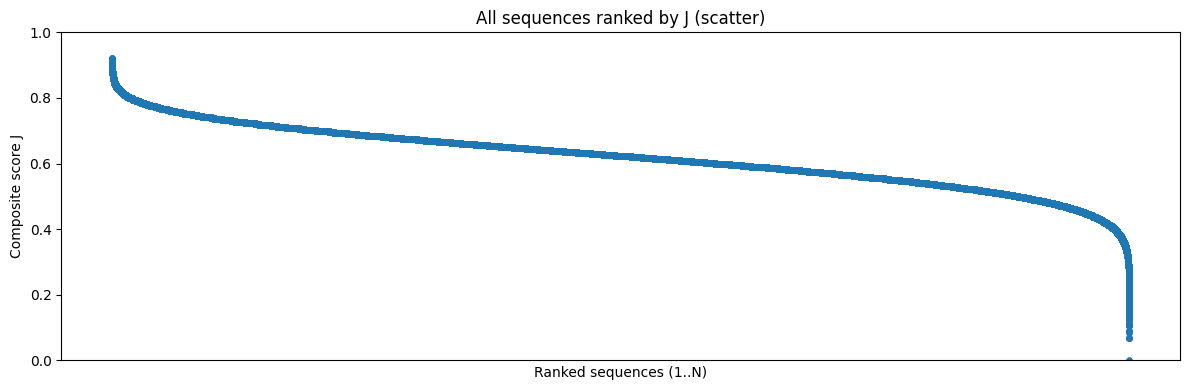

In [ ]:
# Scatter of all sequence scores (J) vs rank (1..N), no x-axis numbers, single points.
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Prefer already-sorted-by-J file; otherwise compute J from the raw file.
sorted_path = Path("scrambled_all_stream1_with_norm_sorted.csv")
raw_path    = Path("scrambled_all_stream1.csv")

def infer_n(path: Path, sample_rows: int = 1000) -> int:
    df = pd.read_csv(path, nrows=sample_rows)
    return int(df["sequence"].astype(str).str.len().mode().iat[0])

def add_norm_and_J(df: pd.DataFrame, n: int) -> pd.DataFrame:
    denomK = n*(n-1)
    denomF = (n*n)//2
    out = df.copy()
    out["K_hat"] = (2.0*out["kendall_inversions"].astype(float))/denomK if denomK>0 else 0.0
    out["H_hat"] = (out["hamming"].astype(float))/n if n>0 else 0.0
    out["F_hat"] = (out["footrule"].astype(float))/denomF if denomF>0 else 0.0
    out["J"] = (out["K_hat"] + out["H_hat"] + out["F_hat"]) / 3.0
    return out

if sorted_path.exists():
    df = pd.read_csv(sorted_path)
    if "J" not in df.columns:
        raise ValueError("Expected 'J' column in the sorted CSV.")
else:
    if not raw_path.exists():
        raise FileNotFoundError("Input CSV not found. Provide either the sorted or raw file.")
    n = infer_n(raw_path)
    df_raw = pd.read_csv(raw_path)
    df = add_norm_and_J(df_raw, n).sort_values("J", ascending=False)

# Build rank index (1..N) and plot
df = df.reset_index(drop=True)
df["rank"] = df.index + 1
plt.figure(figsize=(12, 4))
plt.scatter(df["rank"].values, df["J"].values, s=12)  # single points; default color
plt.xlabel("Ranked sequences (1..N)")
plt.ylabel("Composite score J")
plt.title("All sequences ranked by J (scatter)")
plt.xticks([])           # hide numeric tick labels on x-axis as requested
plt.ylim(0, 1)           # J is in [0,1]
plt.tight_layout()
plt.savefig("J_rank_scatter.png", dpi=200)
plt.show()

